# 🏷️ Part 2.2 - Extract job skills using a curated skill list

**Author:** Yu Kyung Koh  
**Last Updated:** July 12, 2025  

---

### 🎯 Objective

* This notebook extracts job-relevant skills from job posting texts using a curated list of standardized skills (provided by Lightcast).
* The Lightcast skill list includes thousands of skills spanning technical, soft, and domain-specific areas.
* By matching job descriptions to this predefined skill list, we can identify the most frequently requested skills within each job category.
  
  
### 🗂️ Outline
* **Section 1:** Bring in and clean the list of job skills compiled by Lightcast  
* **Section 2:** Bring in the job posting data
* **Section 3:** Job skill extraction using skills_list
* **Section 4:** Wordcloud for most required skill for each job category


---
## SECTION 1: Bring in and clean the list of job skills compiled by Lightcast 

In [3]:
import pandas as pd
import os
import re
from tqdm import tqdm
import multiprocessing 
from joblib import Parallel, delayed

import nltk
from nltk.corpus import stopwords
#from rapidfuzz import process, fuzz

In [4]:
# --------------------------------------
# STEP 1: Import skill list data 
# --------------------------------------
datadir = '../data/Lightcast/'
skills_file = os.path.join(datadir, 'lightcast_skills.csv')

skills_df = pd.read_csv(skills_file)

In [5]:
skills_df.head()

,skill_name,skill_category
0,.NET Assemblies,Specialized Skill
1,.NET Development,Specialized Skill
2,.NET Framework,Specialized Skill
3,.NET Framework 1,Specialized Skill
4,.NET Framework 3,Specialized Skill


In [6]:
# --------------------------------------
# STEP 2: Examine skill category
# --------------------------------------
skills_df["skill_category"].value_counts()  

skill_category
Specialized Skill    30488
Certification         3453
Common Skill           471
Name: count, dtype: int64

In [7]:
# -------------------------------------------------
# STEP 3: Preprocess and Normalize Skill List (e.g., remove parentheses, lowercase, etc.)
# -------------------------------------------------
# Extract content inside parentheses into a new column
skills_df['skill_parentheses'] = skills_df['skill_name'].str.extract(r'\((.*?)\)')

In [8]:
# Remove everything in parentheses from the 'skill' column (e.g. "Python (Programming Language)")
skills_df['skill_name'] = skills_df['skill_name'].str.replace(r'\s*\(.*?\)', '', regex=True)

In [9]:
# Drop duplicates and missing values 
skills_df = skills_df.dropna(subset=['skill_name'])
skills_df = skills_df.drop_duplicates(subset='skill_name')

In [10]:
# Convert to lowercase and strip whitespace
skills_df['skill_name'] = skills_df['skill_name'].str.lower().str.strip()

In [11]:
# Create a list of "Specialized Skill and Certification" and "Common Skill" 
specialized_skills = skills_df[
    skills_df['skill_category'].isin(['Specialized Skill', 'Certification'])
]['skill_name'].dropna().unique().tolist()

common_skills = skills_df[
    skills_df['skill_category'] == 'Common Skill'
]['skill_name'].dropna().unique().tolist()

In [12]:
# -------------------------------------------------
# STEP 4: Augment the skill list & remove confusing terms, etc. 
# -------------------------------------------------
# Augment the list to include (AI, ML, NLP, SQL, API, etc.) 
specialized_skills = list(set(specialized_skills + ['ai', 'ml', 'nlp', 'sql', 'api', 'aws', 'microsoft suite', 'seo tools']))  # this ensures that there are no duplicates 

In [13]:
# Remove terms like "make" from the skills_list, because it confuses the skills with a commonly used verb
specialized_skills = [s for s in specialized_skills if s.lower() not in {'make', 'track', 'disabilities', 'diversity and inclusion', 'transparency'}]
#specialized_skills

In [14]:
# Allowing for common spacing mistakes in the job posting 
alias_map = {
    "photo shop": "photoshop",
    "power point": "powerpoint",
    "word press": "wordpress",
    "excel sheet": "excel",
    # Add more as you find
}

# Add alias keys to skills list
specialized_skills += list(alias_map.keys())


---
## SECTION 2: Bring in the job posting data 

In [16]:
# --------------------------------------
# STEP 1: Import data and clean
# --------------------------------------
datadir = '../data/'
jobposting_file = os.path.join(datadir, 'synthetic_job_postings_combined.csv')

posting_df = pd.read_csv(jobposting_file)

In [17]:
posting_df.head()

,job_title,posting_text,sector
0,Educational Program Coordinator,We are seeking an enthusiastic Educational Pro...,education
1,Healthcare Data Analyst,We are seeking a detail-oriented Healthcare Da...,healthcare
2,Strategic Operations Consultant,"**Location:** Hybrid (New York, NY) \n**Salar...",consulting
3,Financial Operations Specialist,"**Location:** Hybrid (New York City, NY) \n**...",finance
4,Marketing Data Analyst,We are seeking a detail-oriented Marketing Dat...,marketing


In [18]:
# Check how many job postings are in this data 
len(posting_df)

10877

In [19]:
# --------------------------------------
# STEP 2: Convert every letter to lowercase
# --------------------------------------
## Lower case
posting_df['posting_text'] = posting_df['posting_text'].apply(lambda x: " ".join(x.lower()for x in x.split()))

---
## SECTION 3: Job skill extraction using skills_list

In [21]:
# -----------------------------
# Step 1: Define a skill extractor
# -----------------------------
from flashtext import KeywordProcessor

# Initialize and populate the KeywordProcessor
kp = KeywordProcessor()
for skill in specialized_skills:
    if isinstance(skill, str):
        kp.add_keyword(skill.lower().strip())

# Define skill extraction function using FlashText
def extract_skills(text):
    if not isinstance(text, str):
        return []
    return kp.extract_keywords(text.lower())

In [22]:
# -----------------------------
# Step 2: Try running it for the first job posting 
# -----------------------------
# Apply this for the first entry only. 
extract_skills(posting_df.loc[0, "posting_text"])
print(extract_skills(posting_df.loc[0, "posting_text"]))

['student engagement', 'logistics', 'google workspace']


In [23]:
# -----------------------------
# Step 3: Apply to the whole job posting
# -----------------------------
from tqdm import tqdm
tqdm.pandas(desc="Extracting Skills")
posting_df["skills_extracted"] = posting_df["posting_text"].progress_apply(extract_skills)

Extracting Skills: 100%|████████████████| 10877/10877 [00:01<00:00, 6222.47it/s]


---
## SECTION 4:  Wordcloud for the most required skills for each job category

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Group by job category and count skills
grouped_skills = posting_df.groupby("sector")["skills_extracted"].apply(
    lambda lists: sum(lists.dropna().tolist(), [])  # flatten the list of lists
)

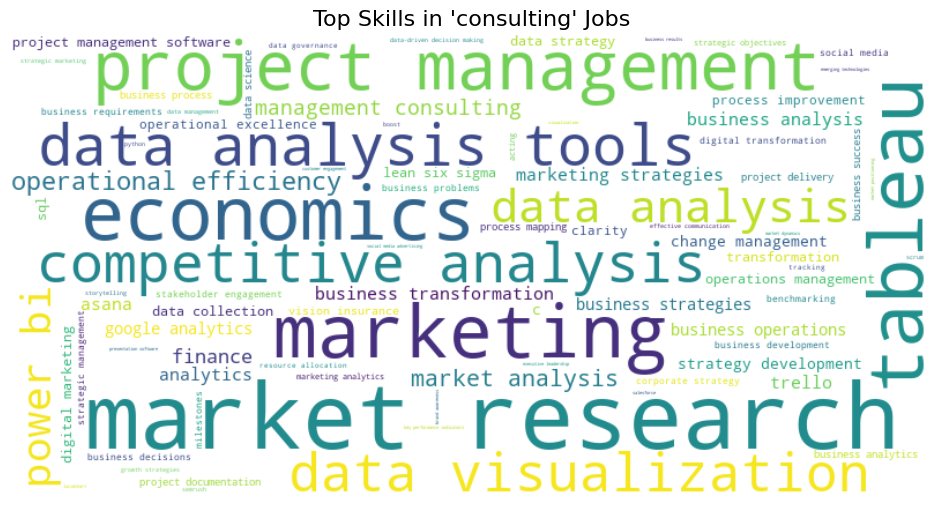

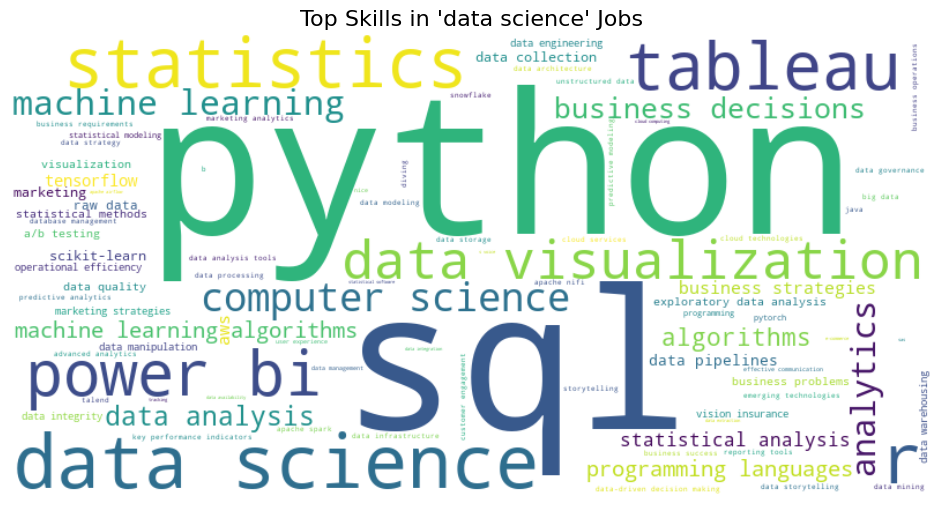

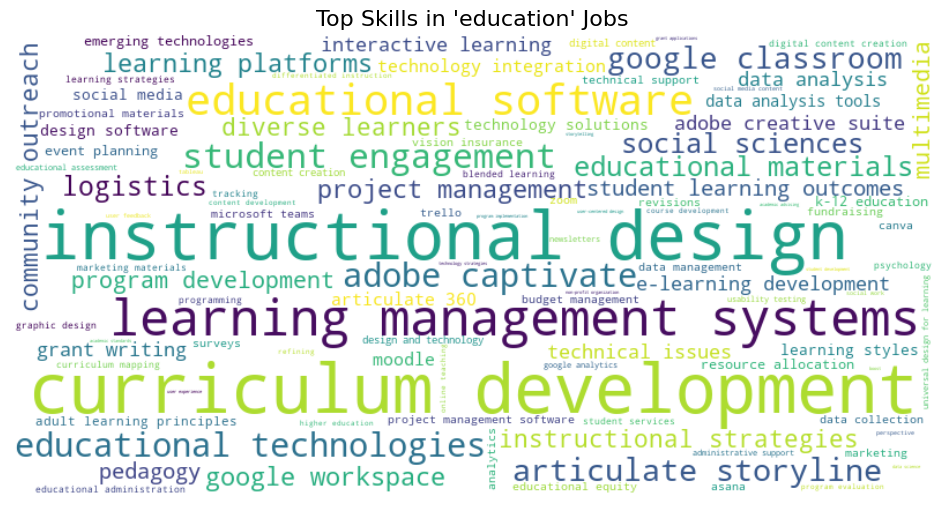

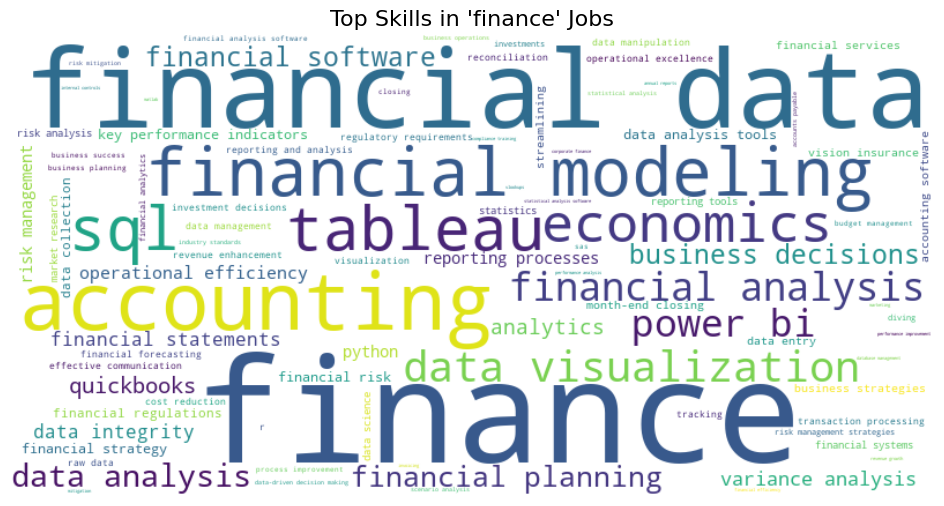

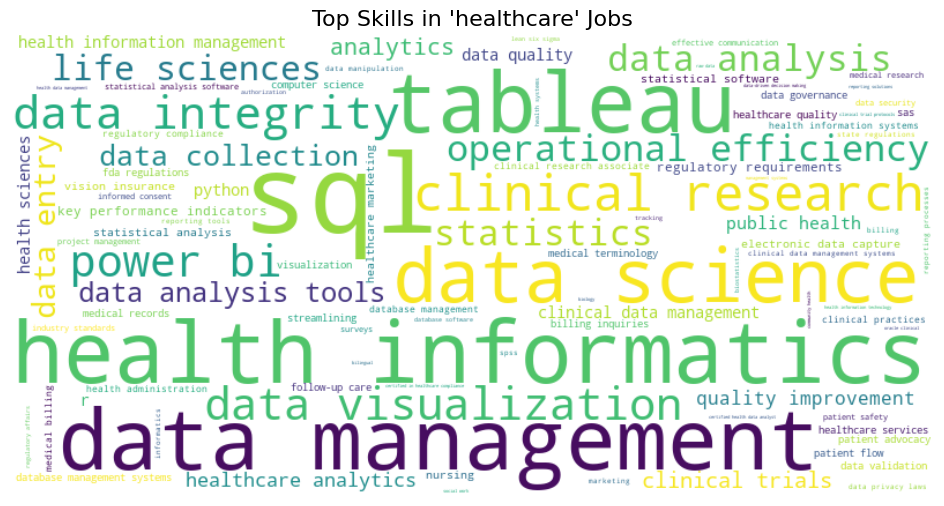

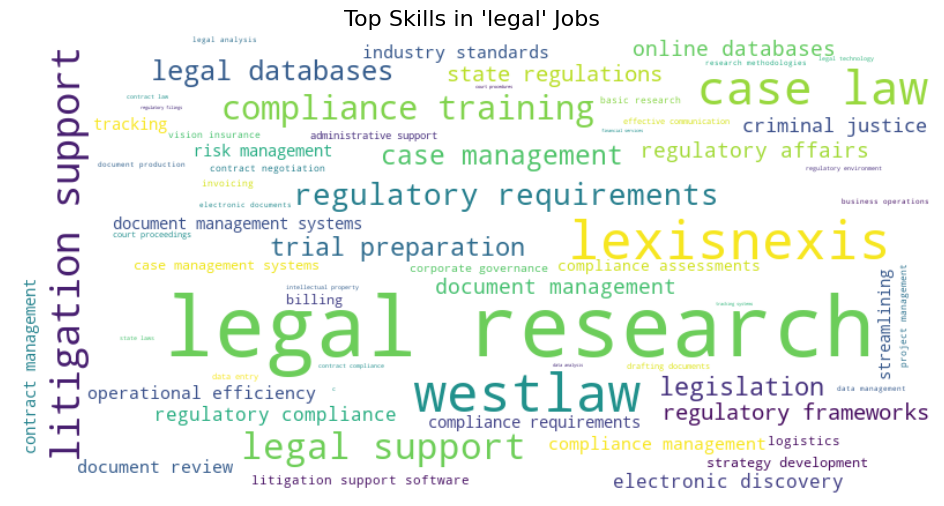

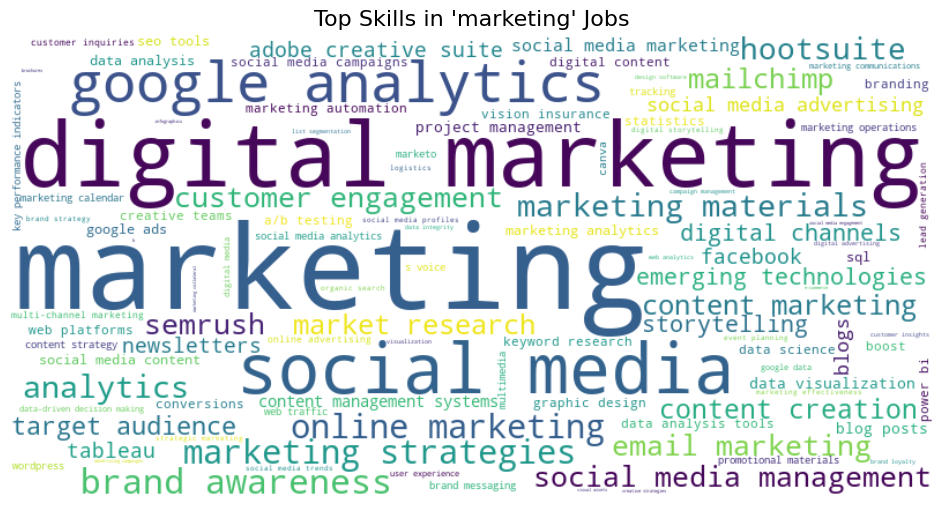

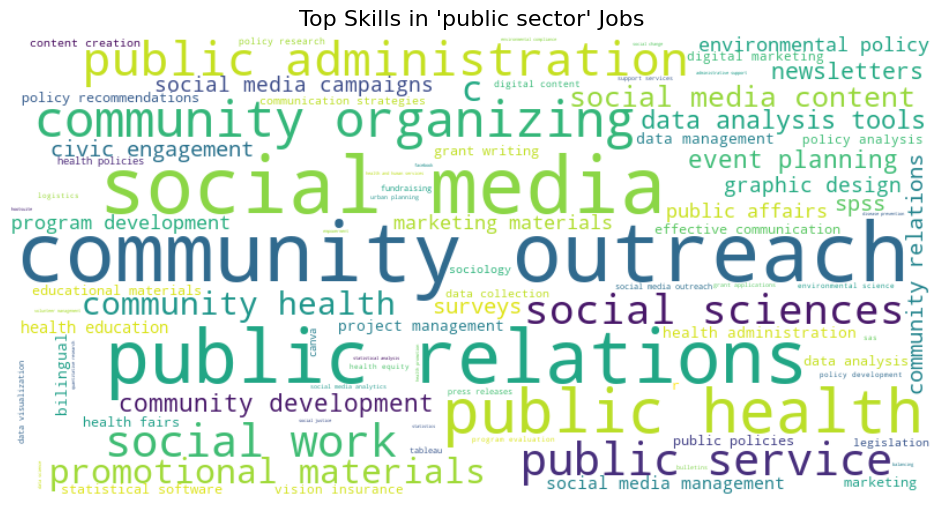

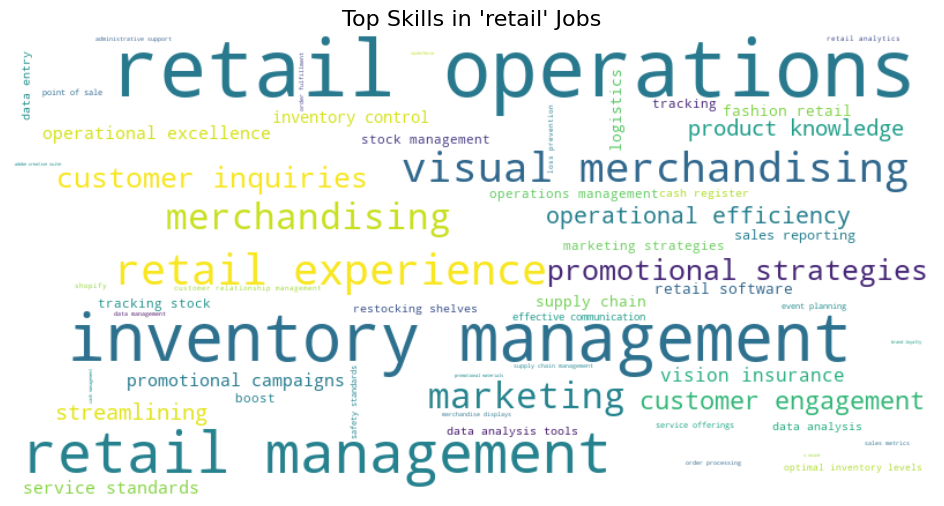

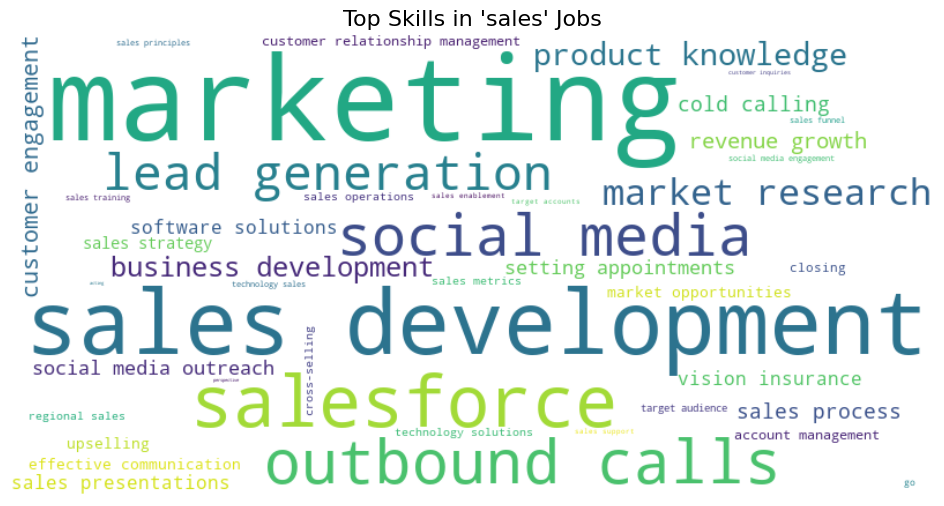

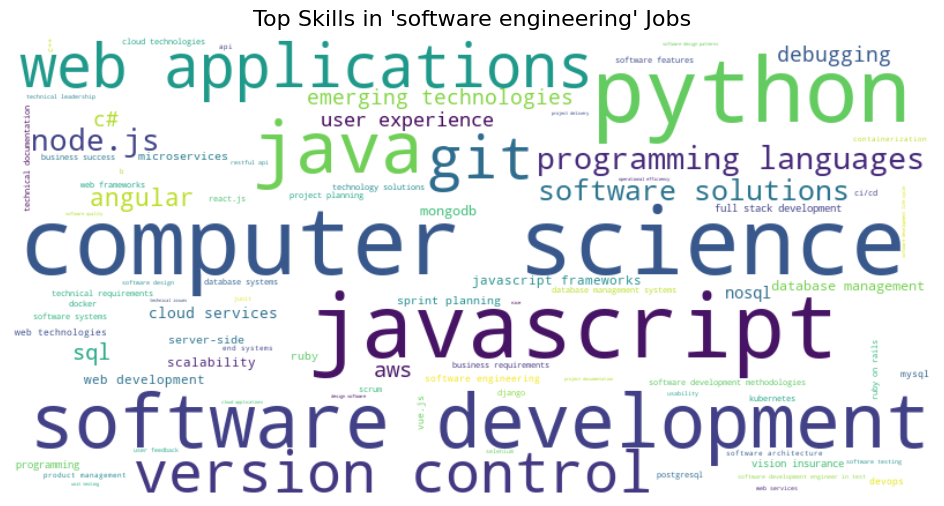

In [26]:
# Loop through each category and create word clouds
for category, skills in grouped_skills.items():
    if not skills:  # skip if empty
        continue

    # Count frequency of each skill
    skill_freq = Counter(skills)

    # Create and configure WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
    wordcloud.generate_from_frequencies(skill_freq)

    # Plot the WordCloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Top Skills in '{category}' Jobs", fontsize=16)
    plt.show()

### 🔷 Comments: 
* The word clouds above demonstrate that **keyword matching using a curated skill list** can do a reasonably good job at identifying relevant job skills from postings.